In [10]:
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf
from IPython.display import FileLink, FileLinks

## FluView Forecasting: Introduction

Earlier this year, preliminary time series modeling was conducted on FluView data. The purpose of this analysis was to develop a baseline model for forecasting cases of all types of flu for North America. We used about 5 years worth of data obtained from the CDC to develop this model. We found the data had seasonal components and was nonstationary, and our recommended model is a "nonstationary ensemble" composed of an ARUMA model (specifically ARUMA(5,0,2), s = 52) and multivariate neural network. In-depth EDA and model testing can be found at the link below:

In [2]:
FileLink('Time_Series_Flu_Data_Forecasting.html')

c:\Users\k\Desktop\QTW\Week7\QTW-CaseStudy4\Time_Series_Flu_Data_Forecasting.html

We will continue this analysis with more depth and breadth. Specifically, we will introduce more data into the analysis, going back to the 2010 flu season. This is a critical time period for 2 reasons: this was data gathered prior to the FluView weekly report which began in 2015 (and thus has combined clinical and public health data, whereas FluView only contains public health). We would like to determine if the methods of gathering these data confound our already-established model. Additionally, the H1N1 swine flu epidemic ended around the beginning of 2010, and we are interested in seeing the effects this has had on tracing the flu from then until now.

Since we will also be conducting analysis on the different sub-types of flu, we will not introduce our neural network component into this analysis; instead, we will focus on our ARUMA model.

## Load the Data

In [3]:
flu2015 = pd.read_csv('Data/WHO_NREVSS_Public_Health_Labs.csv', sep=',', header=0, skiprows=1)
flu2015

,REGION TYPE,REGION,YEAR,WEEK,TOTAL SPECIMENS,A (2009 H1N1),A (H3),A (Subtyping not Performed),B,BVic,BYam,H3N2v
0,National,X,2015,40,1139,4,65,2,10,0,1,0
1,National,X,2015,41,1152,5,41,2,7,3,0,0
2,National,X,2015,42,1198,10,50,1,8,3,2,0
3,National,X,2015,43,1244,9,31,4,9,1,4,0
4,National,X,2015,44,1465,4,23,4,9,1,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...
241,National,X,2020,21,536,0,0,1,0,0,0,0
242,National,X,2020,22,515,2,0,1,1,0,0,0
243,National,X,2020,23,322,0,0,0,1,0,0,0
244,National,X,2020,24,305,0,0,0,1,0,0,0


In [4]:
flu2010 = pd.read_csv('Data/WHO_NREVSS_Combined_prior_to_2015_16.csv', sep=',', header=0, skiprows=1)
flu2010

,REGION TYPE,REGION,YEAR,WEEK,TOTAL SPECIMENS,PERCENT POSITIVE,A (2009 H1N1),A (H1),A (H3),A (Subtyping not Performed),A (Unable to Subtype),B,H3N2v
0,National,X,2010,40,3600,2.13889,7,0,18,29,0,23,0
1,National,X,2010,41,4006,3.19521,13,0,36,43,0,36,0
2,National,X,2010,42,4112,3.38035,8,0,35,51,0,45,0
3,National,X,2010,43,4240,3.91509,13,0,56,45,0,52,0
4,National,X,2010,44,4608,5.36024,12,0,61,68,0,106,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
256,National,X,2015,35,6115,2.27310,3,0,64,43,0,29,0
257,National,X,2015,36,6786,2.18096,1,0,74,35,0,38,0
258,National,X,2015,37,7694,2.57343,4,0,91,56,0,47,0
259,National,X,2015,38,8855,1.88594,1,0,58,62,0,46,0


In [5]:
date_index = pd.date_range(start="2010-10-3", end="2020-6-14", freq='W-SUN')
TS = pd.DataFrame(pd.concat([flu2010['TOTAL SPECIMENS'],flu2015['TOTAL SPECIMENS']]))
FluCases = TS.set_index(date_index)

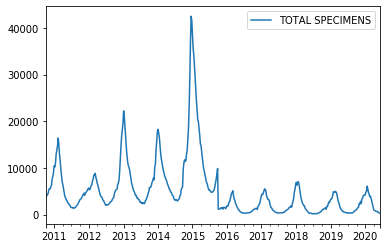

In [6]:
FluCases.plot()
plt.show()

The realization of the Flu Time Series Data show clear peaks repeating around every 50 weeks with the most pronounced peak around week 125. This suggests an annaul trend in the data and is consistent with the fact that influenza viruses typically circulate every year. We suspect the seasonal trend in the data with will be a factor of s = 52 weeks (~1 year). The peaks repeating every year indicate that the mean depends on time and is not constant throughout the time series. Due to this violation, we suspect that time series is a **non-stationary process**.

Assessing the constant variance assumption over time, the peaks all appear to be approximately the same size despite Week 125 being more pronounced. There is some evidence to suggest that the variances do not depend on time, but this is a questional assumption because we can not assume that the mean is constant throughout the time series.

In [7]:
date_index = pd.date_range(start="2015-10-4", end="2020-6-14", freq='W-SUN')
TS = pd.DataFrame(flu2015['TOTAL SPECIMENS'])
FluCases2015 = TS.set_index(date_index)

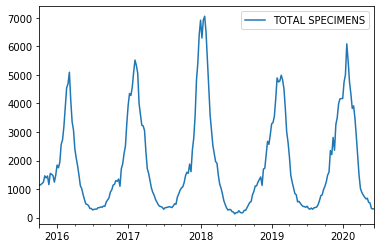

In [8]:
FluCases2015.plot()
plt.show()

Aggregating the data by weeks, we can see that flu activity begins to increase towards the end of the year and peak around the middle of February, (6th week of the year). Activity begins to fall off again around the end of March (roughly the 12th week). This suggests that these trends in flu activity over the past 5 years follow a periodic behavior that cycles annually.

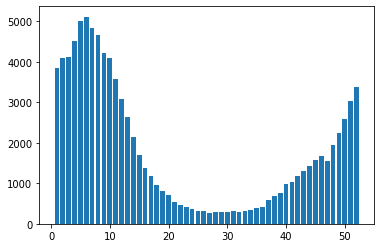

In [9]:
WeekAggregate2015 = flu2015.groupby("WEEK").mean()["TOTAL SPECIMENS"]
plt.bar(WeekAggregate2015.index,WeekAggregate2015)
plt.show()

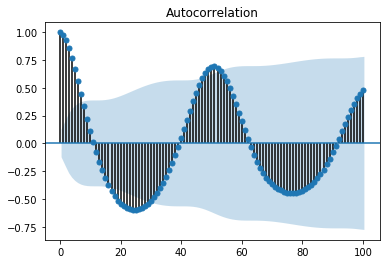

In [13]:
plot_acf(FluCases2015, lags=100)
plt.show()

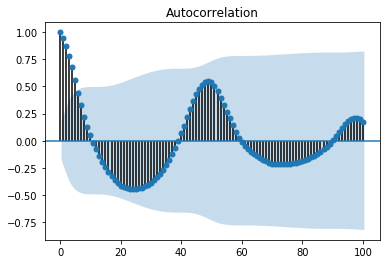

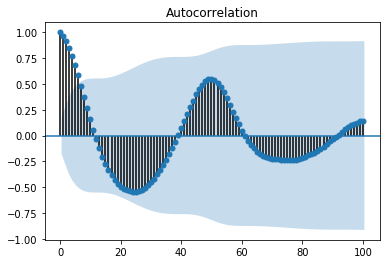

In [26]:
plot_acf(FluCases2015[0:123], lags=100)
plot_acf(FluCases2015[123:246], lags=100)
plt.show()